# CFA for ETS Scale

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ncx2
import scaledev
import seaborn as sns
import matplotlib.pyplot as plt
from semopy import inspector, Model, Optimizer, semplot, calc_stats, report
from scaledev import preprocessor

In [2]:
data_loc = scaledev.get_data_dir()

# Show full dataframes when printing
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(threshold=100, suppress=True)

# load raw data
df_raw = pd.read_excel(data_loc / "cfa.xlsx")
df_raw.head()

,Inclusion1,Inclusion2,Inclusion3,Inclusion4,Inclusion5,Presence1,Presence2,Presence3,Presence4,Presence5,Presence6,Embod1,Embod2,Embod3,Embod4,Embod5,Wonder1,Wonder2,Wonder3,Wonder4,Frequency,Age,Gender,Ethnicity
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4,2,3,1,5
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4,2,4,3,5
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4,3,2,1,5
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4,1,3,3,5
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2,1,3,3,3


In [3]:
# Clean up the column names
df_raw = preprocessor.clean_columns(df_raw)

# Start data cleaning
df = df_raw.copy()

df.head()

,inclusion1,inclusion2,inclusion3,inclusion4,inclusion5,presence1,presence2,presence3,presence4,presence5,presence6,embod1,embod2,embod3,embod4,embod5,wonder1,wonder2,wonder3,wonder4,frequency,age,gender,ethnicity
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4,2,3,1,5
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4,2,4,3,5
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4,3,2,1,5
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4,1,3,3,5
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2,1,3,3,3


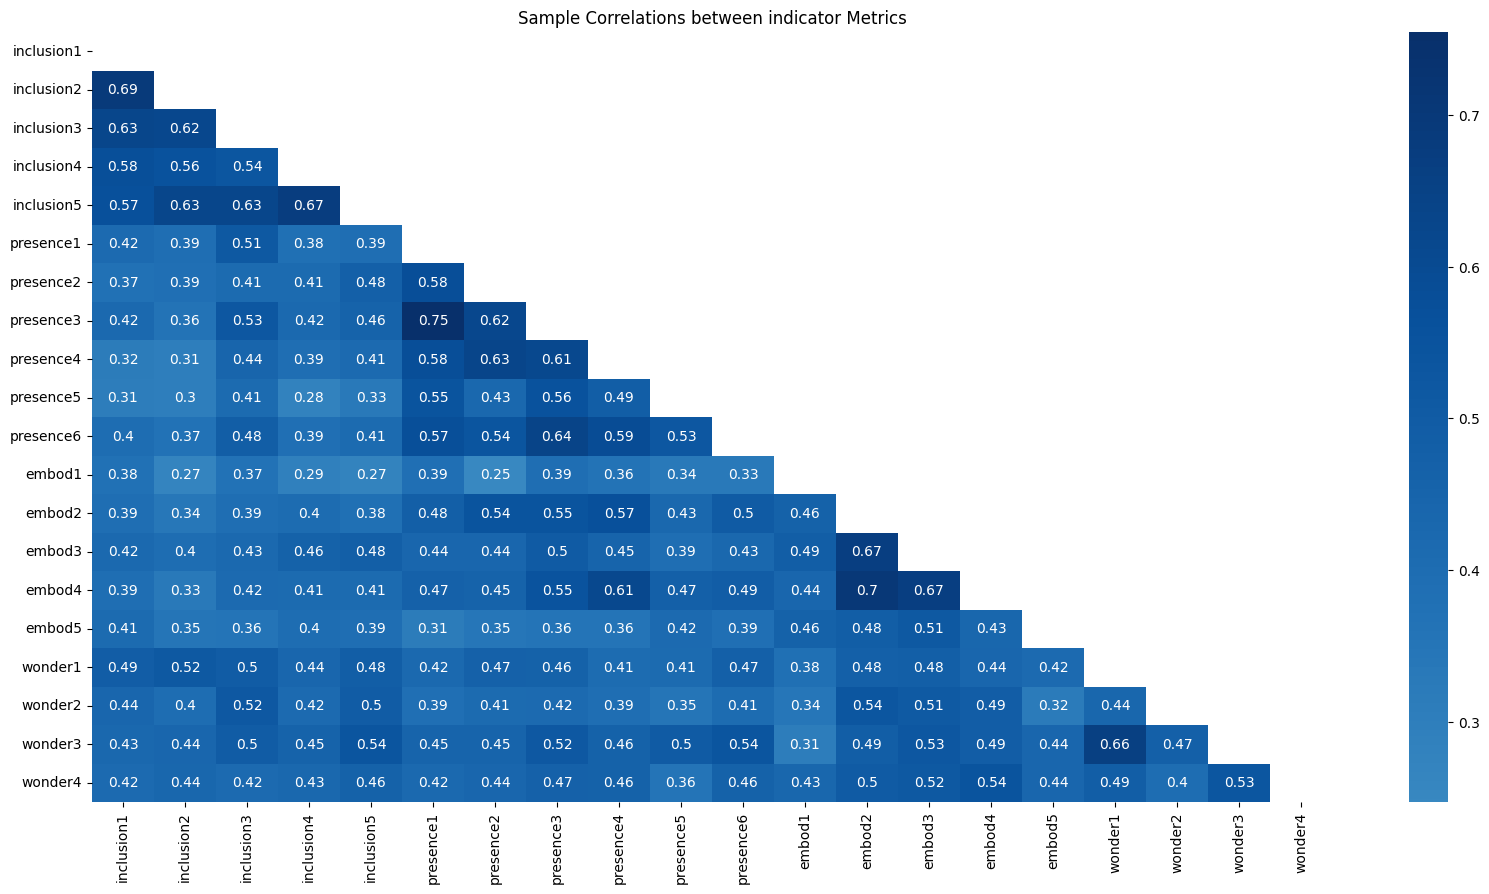

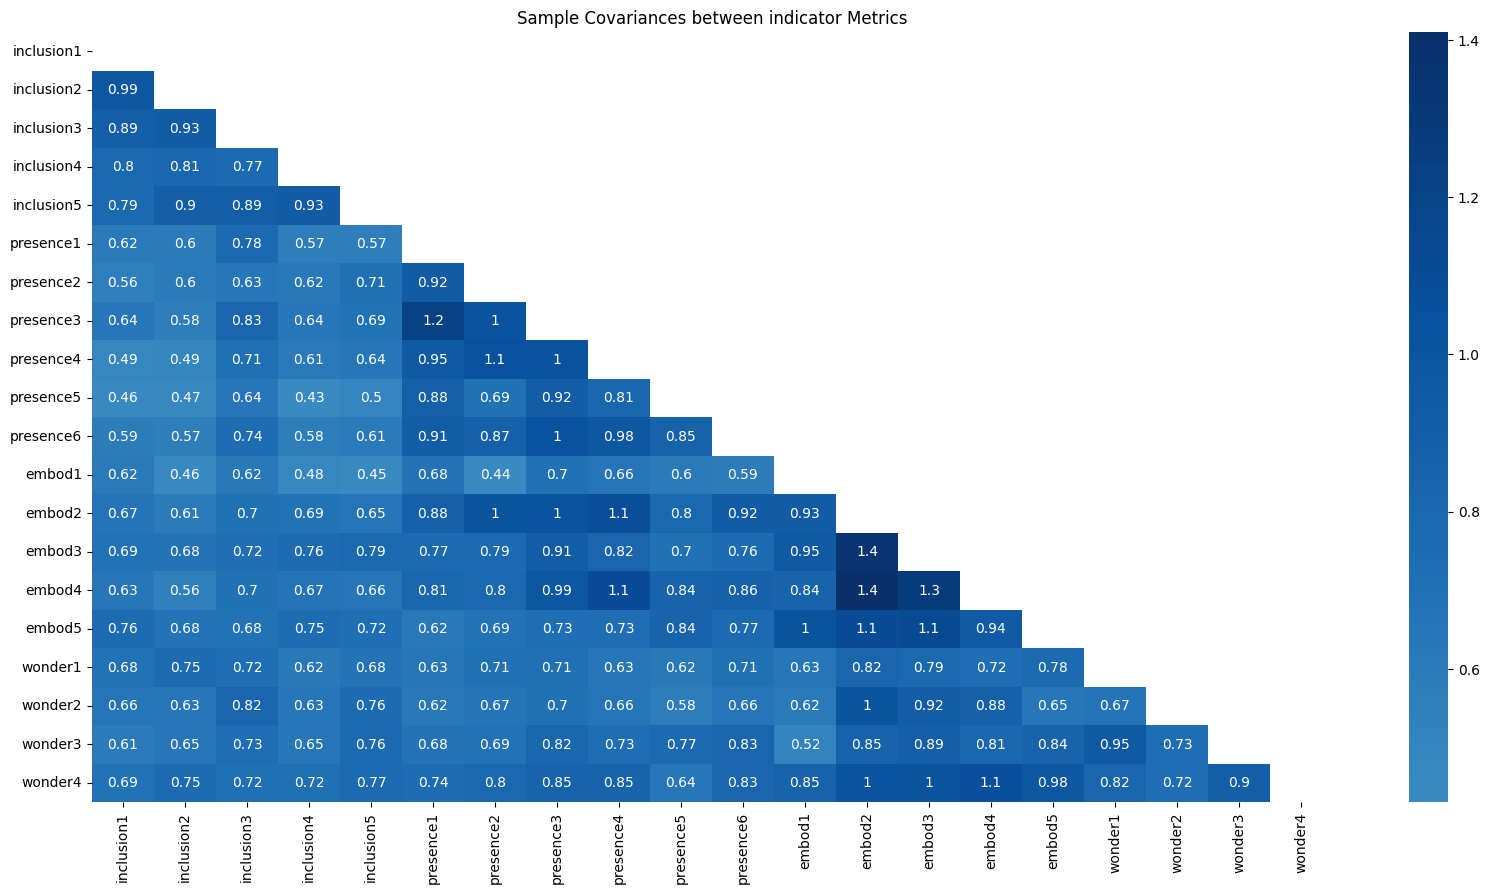

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
drivers = [c for c in df.columns if not c in ["frequency", "age", "gender", "ethnicity"]]
corr_df = df[drivers].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
ax.set_title("Sample Correlations between indicator Metrics")
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df[drivers].cov(), annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
ax.set_title("Sample Covariances between indicator Metrics");

In [5]:
items = [c for c in df.columns if c not in ["frequency", "age", "gender", "ethnicity"]]
df_model = df[items]
df_model.head()

,inclusion1,inclusion2,inclusion3,inclusion4,inclusion5,presence1,presence2,presence3,presence4,presence5,presence6,embod1,embod2,embod3,embod4,embod5,wonder1,wonder2,wonder3,wonder4
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2


In [6]:
model_spec = """
    # Latent variables (factors)
    inclusion =~ inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5
    presence =~ presence1 + presence2 + presence3 + presence4 + presence5 + presence6
    embod =~ embod1 + embod2 + embod3 + embod4 + embod5
    wonder =~ wonder1 + wonder2 + wonder3 + wonder4

    # Factor correlations (allow them to correlate since we used oblique rotations)
    inclusion ~~ presence
    inclusion ~~ embod
    inclusion ~~ wonder
    presence ~~ embod
    presence ~~ wonder
    embod ~~ wonder
"""


model = Model(model_spec)
model.fit(df_model)


SolverResult(fun=np.float64(1.262835306744698), success=np.True_, n_it=56, x=array([1.05743527, 1.04419083, 0.96131241, 1.03392519, 0.93394024,
       1.09975653, 0.98431496, 0.83516982, 0.94551685, 1.48727274,
       1.39373352, 1.38395113, 1.17976618, 0.95783656, 1.05431805,
       1.11288828, 0.61266532, 0.47883099, 0.66110067, 0.8369101 ,
       0.63235658, 0.70393772, 1.01439173, 0.60549608, 0.65757979,
       1.27831607, 0.65447765, 0.66133183, 0.64255846, 1.54946625,
       0.53775579, 0.55833858, 0.56423349, 0.62698238, 0.4793994 ,
       0.55092256, 0.73745574, 0.44123204, 0.71995769, 0.92383835,
       0.69057326, 0.76968231, 0.63950916, 0.94141557, 0.59309202,
       1.02994992]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

In [7]:
# Calculate fit statistics
fit_stats = calc_stats(model)

# Print the fit statistics
fit_stats


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,164,190,452.09504,0.00000,4471.70860,0.93271,0.89890,0.88287,0.89890,0.92205,0.07015,89.47433,267.97885,1.26284


In [8]:
report(model=model, name="ETS Scale", std_est=True)

In [13]:
stats = calc_stats(model)
rmsea = stats['RMSEA']
dof = stats['DoF'] # Degrees of freedom
n = model.n_samples  # Sample size

# Calculate the non-centrality parameter (lambda)
lambda_hat = n * dof * rmsea**2

# Find the lower and upper bounds of the non-centrality parameter
# using the non-central chi-square distribution
alpha = 0.1  # For a 90% CI
lower_lambda = ncx2.ppf(alpha / 2, dof, lambda_hat)
upper_lambda = ncx2.ppf(1 - alpha / 2, dof, lambda_hat)

# Convert the non-centrality parameters back to RMSEA
lower_rmsea = np.sqrt(lower_lambda / (n * dof))
upper_rmsea = np.sqrt(upper_lambda / (n * dof))
 # if lower_lambda is 0, lower_rmsea should also be 0
if lower_lambda == 0:
     lower_rmsea = 0

# Corrected printing: Extract the numerical values using .item()
print(f"RMSEA 90% CI (Manual): ({lower_rmsea.item():.3f}, {upper_rmsea.item():.3f})")


RMSEA 90% CI (Manual): (0.082, 0.094)


In [ ]:
opt = Optimizer(model)
objective_function_value = opt.optimize()

inspector.inspect(opt, std_est=True)

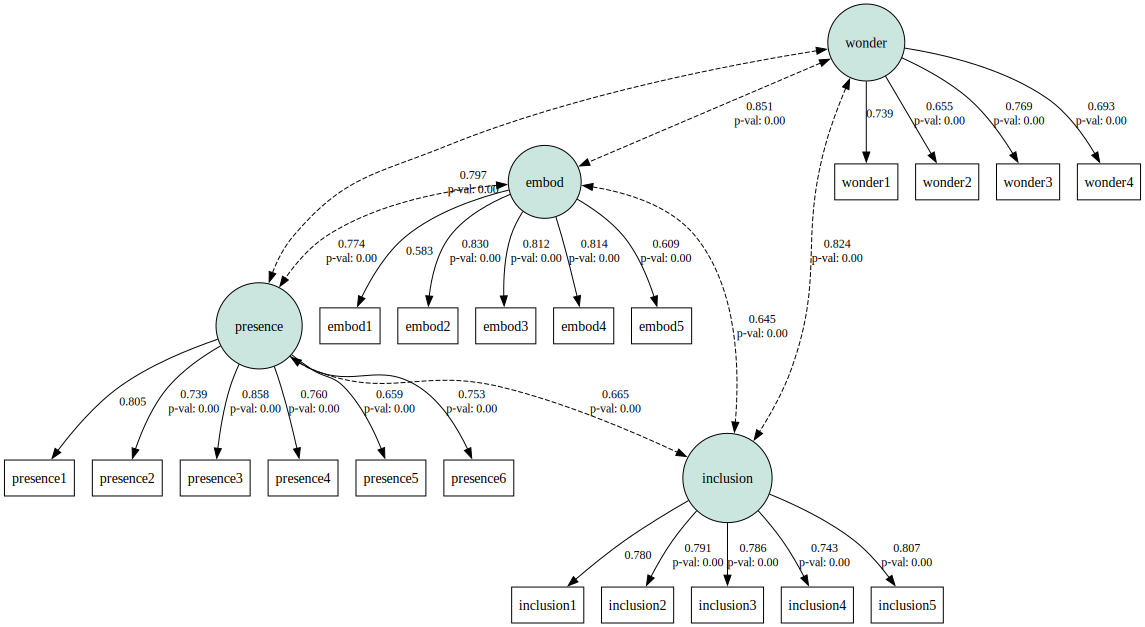

In [ ]:
# path diagram
semplot(mod=model, plot_covs=True, std_ests=True, filename="cfa_model_plot.png")